# Classificação de Dados Planares com uma camada escondida

Bem-vindo a tarefa 3. Está na hora de construir a sua primeira rede neural, a qual conterá uma camada escondida. Você verá uma grande diferença entre este modelo e o modelo utilizando regressão logística.  

**Você irá aprender:**
- Implementar uma rede neural para classificação entre 2 classes com uma única camada escondida
- Utilizar nós com uma função de ativação não-linear, como a tanh. 
- Computa a função de perda utilizando entropia cruzada. 
- Implementar propagação para frente e para trás.


## 1 - Pacotes ##

Primeiro vamos importar todos os pacotes que você irá utilizar nesta tarefa. 
- [numpy](www.numpy.org) é o pacote de computação científica do Python.
- [sklearn](http://scikit-learn.org/stable/) possui ferramentas simples e eficientes para data mining e análise de dados. 
- [matplotlib](http://matplotlib.org) é uma biblioteca para plotar gráficos em Python.
- testCases apresenta alguns exemplos de teste para verificar a implementação de funções.
- planar_utils apresenta várias funções uteis para esta tarefa.

In [2]:
# Importar Pacotes
import numpy as np
import matplotlib.pyplot as plt
from testCases_v2 import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # define um valor de semente para consistência dos resultados

## 2 - Base de dados ##

Primeiro vamos carregar a base de dados que será utilizada nesta tarefa. O código na célula abaixo irá carregar a "flor" uma base de dados com duas classes nas variáveis `X` e `Y`.

In [3]:
X, Y = load_planar_dataset()

Visualize a base de dados utilizando a matplotlib. Os dados lembram uma "flor" com alguns pontos vermelhos (classificação y=0) e alguns pontos azuis (y=1). Sua tarefa é construir um modelo que se ajuste a estes dados.  

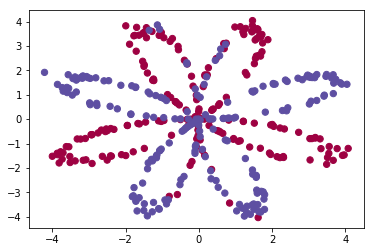

In [4]:
# Visualize os dados:
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral);

Você tem:
    - um array (matrix) numpy, X, que contém os valores das características (x1, x2)
    - um array (vetor) numpy, Y, que contém a classificação (vermelha:0, azul:1).

Vamos primeiro obter uma melhor noção sobre estes dados. 

**Exercício**: Quantos exemplos de treinamento existem? Além disso, qual é o `formato` das variáveis `X` e `Y`? 

**Dica**: Como você determina o formato de um array numpy? [(ajuda)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

In [5]:
### INICIE O SEU CÓDIGO AQUI ### (≈ 3 linhas de código)

shape_X = X.shape
shape_Y = Y.shape
m = Y.shape[1]  # tamanho do conjunto de treinamento

### TÉRMINO DO CÓDIGO ###

print ('O formato de X é: ' + str(shape_X))
print ('O formato de Y é: ' + str(shape_Y))
print ('Existem m = %d exemplos no conjunto de treinamento!' % (m))

O formato de X é: (2, 400)
O formato de Y é: (1, 400)
Existem m = 400 exemplos no conjunto de treinamento!


**Saída Esperada**:
       
<table style="width:20%">
  
  <tr>
    <td>**formato de X**</td>
    <td> (2, 400) </td> 
  </tr>
  
  <tr>
    <td>**formato de Y**</td>
    <td>(1, 400) </td> 
  </tr>
  
    <tr>
    <td>**m**</td>
    <td> 400 </td> 
  </tr>
  
</table>

## 3 - Regressão Logística Simples

Antes de construir uma rede neural completa, vamos primeiro ver como a regressão logística se sai neste problema. Você poderia utilizar a função pronta sklearn para fazer isto. Execute o código abaixo para treinar uma regressão logística com a base de dados. 

In [6]:
# Treinar um classificador com regressão logística
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

/Users/ahirtonlopes/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


É possível agora plotar a linha de decisão deste modelo executando o código abaixo.

A precisão da regressão logística é: 47 % (porcentagem de pontos classificados corretamente)


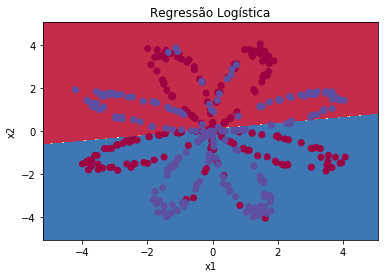

In [7]:
# Plotar a linha de decisão da regressão logística
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Regressão Logística")

# Imprimir precisão
LR_predictions = clf.predict(X.T)
print ('A precisão da regressão logística é: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(porcentagem de pontos classificados corretamente)")

**Saída Esperada**:

<table style="width:20%">
  <tr>
    <td>**Precisão**</td>
    <td> 47% </td> 
  </tr>
  
</table>


**Interpretação**: O conjunto de dados não é linearmente separável, logo, regressão logística não vai apresentar um bom desempenho. Espera-se que a rede neural seja bem melhor. Vamos experimentar! 

## 4 - Modelo de Rede Neural

Regessão logística não funcionou bem com a base de dados "flor". Vamos treinar uma Rede Neural com uma única camada escondida e ver como ela se sai. 

**Este é o modelo**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Matematicamente**:

Para um exemplo $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Dada a previsão sobre todos os exemplos é possível determinar o custo $J$ da seguinte forma: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Lembre-se**: A metodologia geral para construir uma Rede Neural é: 
    1. Definir a estrutura da rede neural ( # de nós de entrada,  # de nós escondidos, etc). 
    2. Inicializar os parâmetros do modelo
    3. Loop:
        - Implementar propagação para frente
        - Computar perda
        - Implementar propagação para trás e determinar os gradientes
        - Atualizar os parâmetros (gradiente descendente)

Geralmente se constroem funções auxiliares par computar as etapas 1-3 e então criamos uma função modelo composta das funções auxiliares que chamamos de `modelo_rn()`. Uma vez construído o modelo `modelo_rn()` e aprendido os parâmetros corretamente, é possível realizar previsões sobre dados novos.

### 4.1 - Definindo a estrutura de uma rede neural ####

**Exercício**: Defina três variáveis:
    - n_x: o tamanho da camada de entrada
    - n_h: o tamanho da camada escondida (ajuste este valor para 4) 
    - n_y: o tamanho da camada de saída

**Dica**: Use o formato de X e Y para encontrar n_x e n_y. Defina o tamanho da camada escondida como 4.

In [8]:
# FUNÇÃO DE AVALIAÇÃO: Tamanho_Camadas

def Tamanho_Camadas(X, Y):
    """
    Argumentos:
    X -- dados de entrada no formato (tamanho da entrada, número de exemplos)
    Y -- classificação no formato (tamanho da saída, número de exemplos)
    
    Retorna:
    n_x -- o tamanho da camada de entrada
    n_h -- o tamanho da camada escondida
    n_y -- o tamanho da camada de saída
    """
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 3 linhas de código)
    
    n_x = X.shape[0] # tamanho da camada de entrada
    n_h = 4
    n_y = Y.shape[0] # tamanho da camada de saída                      
    
    ### TÉRMINO DO CÓDIGO ###
    return (n_x, n_h, n_y)

In [9]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = Tamanho_Camadas(X_assess, Y_assess)
print("O tamanho da camada de entrada é: n_x = " + str(n_x))
print("O tamanho da camada escondida é: n_h = " + str(n_h))
print("O tamanho da camada de saída é: n_y = " + str(n_y))

O tamanho da camada de entrada é: n_x = 5
O tamanho da camada escondida é: n_h = 4
O tamanho da camada de saída é: n_y = 2


**Saida Esperada** (estes não são os tamanhos que você irá utilizar na sua rede neural, eles foram utilizados aqui apenas para testar o seu código).

<table style="width:20%">
  <tr>
    <td>**n_x**</td>
    <td> 5 </td> 
  </tr>
  
    <tr>
    <td>**n_h**</td>
    <td> 4 </td> 
  </tr>
  
    <tr>
    <td>**n_y**</td>
    <td> 2 </td> 
  </tr>
  
</table>

### 4.2 - Inicialização dos parâmetros do modelo ####

**Exercício**: Implemente a função `inicializar_parametros()`.

**Instruções**:
- Tenha a certeza de que o tamanho das matrizes/vetores de inicialização estão corretos. Reveja a rede neural da figura acima caso ache necessário.
- Inicialize as matrizes de peso com valores aleatórios. 
    - Utilize: `np.random.randn(a,b) * 0.01` para criar uma matriz aleatória no formato (a,b).
- Inicialize o vetor de bias com zeros. 
    - Utilize: `np.zeros((a,b))` para criar uma matriz de zeros no formato (a,b).

In [10]:
# FUNÇÃO DE AVALIAÇÃO: inicializar_parametros

def inicializar_parametros(n_x, n_h, n_y):
    """
    Argumentos:
    n_x -- número de nós na camada de entrada
    n_h -- número de nós na camada escondida
    n_y -- número de nós na camada de saída
    
    Retorna:
    params -- um dicionário python contendo:
                    W1 -- matriz de pesos no formato (n_h, n_x)
                    b1 -- vetor bias no formato (n_h, 1)
                    W2 -- matriz de pesos no formato (n_y, n_h)
                    b2 -- vetor bias no formato (n_y, 1)
    """
    
    np.random.seed(2) # definimos a semente do gerador de números aleatórios para comparar resultados.
    
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 4 linhas de código)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    ### TÉRMINO DO CÓDIGO ###
    # verifica os formatos do que foi gerado
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    #cria o dicionário
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [11]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = inicializar_parametros(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[ 0.]]


**Saída Esperada**:

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]] </td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] </td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01057952 -0.00909008  0.00551454  0.02292208]]</td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.]] </td> 
  </tr>
  
</table>



### 4.3 - O Loop ####

**Exercício**: Implemente `propagação_para_frente()`.

**Instruções**:
- Veja acima a representação matemática do seu classificador.
- Utilize a função `sigmoid()`. Ela está pré-definida (importada) neste notebook.
- Utilize a função `np.tanh()`. Ela faz parte da biblioteca numpy.
- Implemente as seguintes etapas:
    1. Recupere cada matriz/vetor de parâmetros do dicionário "parameters" (que é a saída da função `inicializar_parametros()`) usando `parametros[".."]`.
    2. Implemente a propagação para frente. Determine $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (o vetor com todas as previsões sobre todos os exemplos do conjunto de treinamento).
- Os valores necessários para a propagação para trás serão armazenados na "`cache`". A `cache` será passada como entrada da função de propagação para trás.

In [12]:
# FUNÇÃO DE AVALIAÇÃO: propagacao_para_frente

def propagacao_para_frente(X, parametros):
    """
    Argumentos:
    X -- dados de entrada no tamanho (n_x, m)
    parametros -- dicionário python contendo os parâmetros (saída da função de inicialização)
    
    Retornas:
    A2 -- a saída da função sigmoid da segunda ativação
    cache -- um dicionário contendo "Z1", "A1", "Z2" and "A2"
    """
    # Recupere cada parâmetro do dicionário de parametros
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 4 linhas de código)
    
    W1 = parametros['W1']
    b1 = parametros['b1']
    W2 = parametros['W2']
    b2 = parametros['b2']
    
    ### TÉRMINO DO CÓDIGO ###
       
    # Implemente a propagação para frente para calcular A2 (probabilidades)
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 4 linhas de código)
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    ### TÉRMINO DO CÓDIGO ###
    # verifica o formato de A2
    assert(A2.shape == (1, X.shape[1]))
    # cria o dicionário de saída
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [13]:
X_assess, parametros = forward_propagation_test_case()
A2, cache = propagacao_para_frente(X_assess, parametros)

# Nota: neste caso é utilizada a média somente para garantir que as saídas são compatíveis. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

0.262818640198 0.091999045227 -1.30766601287 0.212877681719


**Saída Esperada**:
<table style="width:50%">
  <tr>
    <td> 0.262818640198 0.091999045227 -1.30766601287 0.212877681719 </td> 
  </tr>
</table>

Agora que você determinou o valor de $A^{[2]}$ (na variável "`A2`" do Python), que contém $a^{[2](i)}$ para cada exemplo, você pode determinar a função de custo da seguinte forma:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**Exerc;icio**: Implemente `computar_custo()` para determinar o valor do custo $J$.

**Instruções**:
- Existem diversas formas de se implementar a perda por entropia cruzada. Para ajudá-lo, mostramos abaixo como ela poderia ser implementada.
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # não é necessário fazer um loop!
```

(voce pode utilizar tanto o `np.multiply()` e então `np.sum()` ou diretamente `np.dot()`).


In [14]:
# FUNÇÃO DE AVALIAÇÃO: computar_custo

def computar_custo(A2, Y, parametros):
    """
    Computa o custo por entropia cruzada mostrado na equação (13)
    
    Argumentos:
    A2 -- O valor de saída da segunda ativação no formato (1, número de exemplos)
    Y --  vetor de classificação real no formato (1, número de exemplos)
    parametros -- dicionário python contendo os parâmetros W1, b1, W2 e b2
    
    Retorna:
    custot -- o custo por entropis cruzada de acordo com a equação (13)
    """
    
    m = Y.shape[1] # número de exemplos
    
    W1 = parametros['W1']
    W2 = parametros['W2']

    # Computação do custo por entropia cruzada
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 2 linhas de código)
    
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    
    ### TÉRMINO DO CÓDIGO ###
    
    cost = np.squeeze(cost)     # verifique que as dimensões estão corretas. 
                                # por exemplo, transforme [[17]] em 17 
    assert(isinstance(cost, float))
    
    return cost

In [15]:
A2, Y_assess, parameters = compute_cost_test_case()

print("custo = " + str(computar_custo(A2, Y_assess, parameters)))

custo = 0.693058761039


**Saída Esperada**:
<table style="width:20%">
  <tr>
    <td>**custo**</td>
    <td> 0.693058761... </td> 
  </tr>
  
</table>

Usando a cache computada durante a propagação para frente, é possível determinar a propagação para trás.

**Exercício**: Implemente a função `propagação_para_tras()`.

**Instruções**:
A propagação para trás geralmente é a mais difícil de ser implementada em deep learning por ser mais matemática. Para ajudá-lo mostramos abaixo a propagação para trás. Você deve utilizar as seis equações mostradas no lado direito pois estamos utilizando vetorização.   

<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note que $*$ indica multiplicação elemento a elemento.
- A notação a ser utilizada é comum na codificação de deep learning: 
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- Dicas:
    - Para computar dZ1 você precisa computar $g^{[1]'}(Z^{[1]})$. Como $g^{[1]}(.)$ é a função de ativação tanh, se $a = g^{[1]}(z)$ então $g^{[1]'}(z) = 1-a^2$. E você pode determinar 
    $g^{[1]'}(Z^{[1]})$ usando `(1 - np.power(A1, 2))`.

In [16]:
# FUNÇÃO DE AVALIAÇÃO: propagação_para_tras

def propagacao_para_tras(parametros, cache, X, Y):
    """
    Implemente a propagação para trás usando as instruções acima.
    
    Argumentos:
    parametros -- dicionário python contendo os parâmetros 
    cache -- um dicionário contendo "Z1", "A1", "Z2" e "A2".
    X -- dados de entrada no formato (2, numero de exemplos)
    Y -- vetor com a classificação correta de cada exemplo no formato (1, numero de exemplos)
    
    Retorna:
    grads -- um dicionário python contendo os gradientes com relação a cada parâmetro
    """
    m = X.shape[1]
    
    # 1) recupere as metrizes W1 e W2 dos parametros.
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 2 linhas de código)
    
    W1 = parametros['W1']
    W2 = parametros['W2']
    
    ### TÉRMINO DO CÓDIGO ###
        
    # 2) recupere A1 e A2 do dicionario cache. 
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 2 linhas de código)
    
    A1 = cache['A1']
    A2 = cache['A2']
    
    ### TÉRMINO DO CÓDIGO ###
    
    # Propagacao para tras: determine dW1, db1, dW2, db2. 
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 6 linhas de código, correspondendo às 6 equações acima)
    
    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    ### TÉRMINO DO CÓDIGO ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [17]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = propagacao_para_tras(parametros, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]


**Saída Esperada**:



<table style="width:80%">
  <tr>
    <td>**dW1**</td>
    <td> [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]] </td> 
  </tr>
  
  <tr>
    <td>**db1**</td>
    <td>  [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]] </td> 
  </tr>
  
  <tr>
    <td>**dW2**</td>
    <td> [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]] </td> 
  </tr>
  

  <tr>
    <td>**db2**</td>
    <td> [[-0.16655712]] </td> 
  </tr>
  
</table>  

**Exercício**: Implemente a regra para atualizar os parâmetros. Use gradiente descendente. Você deve utilizar (dW1, db1, dW2, db2) para atualizar (W1, b1, W2, b2).

**Regra Geral do Gradiente Descendente**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ onde $\alpha$ é a taxa de aprendizado e $\theta$ representa um parâmetro.

**Ilustração**: O algoritmo de gradiente descendente com uma boa taxa de de aprendizado (convergendo) e uma taxa de aprendizado ruim (divergendo). Imagens, cortesia de Adam Harley.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">



In [18]:
# FUNÇÃO DE AVALIAÇÃO: atualizar_parametros

def atualizar_parametros(parametros, grads, learning_rate = 1.2):
    """
    Atualizacao de parametros utilizando a regra de gradiente descendente dada acima.
    
    Argumentos:
    parametros -- dicionario python contendo os parametros.  
    grads -- dicionario python contendo os gradientes. 
    
    Retorna:
    parametros -- dicionario python contendo os valores de atualizacao dos parametros. 
    """
    # 1) recupere cada parametro do dicionario parametros
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 4 linhas de código)
    
    W1 = parametros['W1']
    b1 = parametros['b1']
    W2 = parametros['W2']
    b2 = parametros['b2']
    
    ### TÉRMINO DO CÓDIGO ###
    
    # 2) Recupere cada gradiente do dicionario grads
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 4 linhas de código)
    
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    
    ## TÉRMINO DO CÓDIGO ###
    
    # 3) regra de atualizacao para cada parametro
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 4 linhas de código)
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    ### TÉRMINO DO CÓDIGO ###
    
    parametros = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parametros

In [19]:
parameters, grads = update_parameters_test_case()
parameters = atualizar_parametros(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[ 0.00010457]]


**Saída Esperada**:


<table style="width:80%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01041081 -0.04463285  0.01758031  0.04747113]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.00010457]] </td> 
  </tr>
  
</table>  

### 4.4 - Integrar as partes 4.1, 4.2 e 4.3 no modelo_rn() ####

**Exercício**: Construa o modelo de rede neural `modelo_rn()`.

**Instruções**: O modelo de rede neural deve utilizar as  funções definidas previamente na ordem correta. 

In [20]:
# FUNÇÃO DE AVALIAÇÃO: modelo_rn

def modelo_rn(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Argumentos:
    X -- dados de entrada no formato (2, numero de exemplos)
    Y -- classificação correta no formato (1, numero de exemplos)
    n_h -- tamanho da camada escondida (número de nós)
    num_iterations -- Número de interações no loop do gradiente descendente
    print_cost -- se True, imprime o valor do custo a cada 1000 interacoes
    
    Retorna:
    parametros -- parametros aprendidos pelo modelo. Eles podem ser utilizados para prever saídas em entradas novas.
    """
    
    np.random.seed(3)
    n_x = Tamanho_Camadas(X, Y)[0]
    n_y = Tamanho_Camadas(X, Y)[2]
    
    # Inicializacao de parametros, então, recupere W1, b1, W2, b2. Entradas: "n_x, n_h, n_y". Saídas = "W1, b1, W2, b2, 
    # parametros".
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 5 linhas de código)
    
    parametros = inicializar_parametros(n_x, n_h, n_y)
    W1 = parametros['W1']
    b1 = parametros['b1']
    W2 = parametros['W2']
    b2 = parametros['b2']
    
    ### TÉRMINO DO CÓDIGO ###
    
    # Loop (gradiente descendente)

    for i in range(0, num_iterations):
         
        ### INICIE O SEU CÓDIGO AQUI ### (≈ 4 linhas de código)
        # propagacao para frente. Entradas: "X, parametros". Saídas: "A2, cache".
        
        A2, cache = propagacao_para_frente(X, parametros)
        
        # funcao de custo. Entradas: "A2, Y, parametros". Saída: "custo".
        
        custo = computar_custo(A2, Y, parametros)
 
        # propagacao para trás. Entradas: "parametros, cache, X, Y". Saídas: "grads".
        
        grads = propagacao_para_tras(parametros, cache, X, Y)
 
        # Atualizacao dos parametros utilizando Gradiente descendente. Entradas: "parametros, grads". Saída: "parametros".
        
        parametros = atualizar_parametros(parametros, grads)
        
        ### TÉRMINO DO CÓDIGO ###
        
        # Imprimir  o custo a cada 1000 interacoes
        if print_cost and i % 1000 == 0:
            print ("Custo após interação %i: %f" %(i, custo))

    return parametros

In [21]:
X_assess, Y_assess = nn_model_test_case()
parametros = modelo_rn(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parametros["W1"]))
print("b1 = " + str(parametros["b1"]))
print("W2 = " + str(parametros["W2"]))
print("b2 = " + str(parametros["b2"]))

Custo após interação 0: 0.692739
Custo após interação 1000: 0.000218
Custo após interação 2000: 0.000107
Custo após interação 3000: 0.000071
Custo após interação 4000: 0.000053
Custo após interação 5000: 0.000042
Custo após interação 6000: 0.000035
Custo após interação 7000: 0.000030
Custo após interação 8000: 0.000026
Custo após interação 9000: 0.000023
W1 = [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]
b1 = [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]]
W2 = [[-2.45566237 -3.27042274  2.00784958  3.36773273]]
b2 = [[ 0.20459656]]


**Saída Esperada**:

<table style="width:90%">

<tr> 
    <td> 
        **custo após a interação 0**
    </td>
    <td> 
        0.692739
    </td>
</tr>

<tr> 
    <td> 
        <center> $\vdots$ </center>
    </td>
    <td> 
        <center> $\vdots$ </center>
    </td>
</tr>

  <tr>
    <td>**W1**</td>
    <td> [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]] </td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-2.45566237 -3.27042274  2.00784958  3.36773273]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.20459656]] </td> 
  </tr>
  
</table>  

### 4.5 Prevendo

**Exercício**: Use o seu modelo para prever saídas de novas entradas utilizando prever().
Use a propagação para frente para prever os resultados.

**Lembre-se**: prever = $y_{previsto} = \mathbb 1 \text{{ativação > 0.5}} = \begin{cases}
      1 & \text{se}\ ativação > 0.5 \\
      0 & \text{caso contrário}
    \end{cases}$  
    
Como exemplo, se você ajustar as entradas de uma matriz X para 0 e 1 baseado no "threshold" você faria: ```X_new = (X > threshold)```

In [22]:
# FUNÇÃO DE AVALIAÇÃO: prever

def prever(parametros, X):
    """
    Utilizando os parâmetros aprendidos, prever uma classe para cada exemplo na entrada X.
    
    Argumentos:
    parâmetros -- dicionário python contendo seus parâmetros 
    X -- Dados de entrada no formato (n_x, m)
    
    Retorna
    previsoes -- vetor de previsões paa nosso modelo (vermelho: 0 / azul: 1)
    """
    
    # Computa as probabilidades usando propagação para frente, e classifica em 0/1 usando 0.5 como threshold.
    ### INICIE O SEU CÓDIGO AQUI ### (≈ 2 linhas de código)
    
    A2, cache = propagacao_para_frente(X, parametros)
    previsoes = np.round(A2)
    
    ### TÉRMINO DO CÓDIGO ###
    
    return previsoes

In [23]:
parametros, X_assess = predict_test_case()

previsoes = prever(parametros, X_assess)
print("média prevista = " + str(np.mean(previsoes)))

média prevista = 0.666666666667


**Saída Esperada**: 


<table style="width:40%">
  <tr>
    <td>**média prevista**</td>
    <td> 0.666666666667 </td> 
  </tr>
  
</table>

Está na hora de executar o seu modelo e ver como ele desempenha em um conjunto de dados planares. Execute o código a seguir para testar seu modelo com uma única camada escondida contendo $n_h$ nós.

Custo após interação 0: 0.693048
Custo após interação 1000: 0.288083
Custo após interação 2000: 0.254385
Custo após interação 3000: 0.233864
Custo após interação 4000: 0.226792
Custo após interação 5000: 0.222644
Custo após interação 6000: 0.219731
Custo após interação 7000: 0.217504
Custo após interação 8000: 0.219430
Custo após interação 9000: 0.218551


Text(0.5,1,'Borda de decisão para uma camada escondida de tamanho 4')

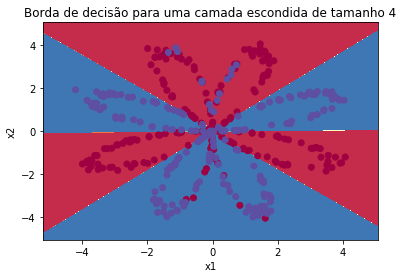

In [24]:
# Construa um modelo com n_h nós na camada escondida 
parametros = modelo_rn(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plotar a borda de limites no plano
plot_decision_boundary(lambda x: prever(parametros, x.T), X, Y)
plt.title("Borda de decisão para uma camada escondida de tamanho " + str(4))

**Saída Esperada**:

<table style="width:40%">
  <tr>
    <td>**Custo após interação 9000**</td>
    <td> 0.218607 </td> 
  </tr>
  
</table>


In [25]:
# Print accuracy
predictions = prever(parametros, X)
print ('Precisao: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Precisao: 90%


**Saída Esperada**: 

<table style="width:15%">
  <tr>
    <td>**Precisão**</td>
    <td> 90% </td> 
  </tr>
</table>

A precisão está realmente alta se comparada com a regressão logística. O modelo aprendeu o padrão das petalas da flor! Redes neurais são capazes de aprender limites de decisão altamente não-lineares, diferente de=a regressão logística. 

Vamos tentar diferentes números de nós na camada escondida.

### 4.6 -  Ajustando o número de nós na camada escondida (opcional) ###

Execute o código abaixo. Ele deve levar entre 2 e 3 minutos. Você deve observar ao final comportamentos diferentes do modelo, dependendo do número de nós na camada escondida.

Precisão para 1 nós escondidos: 67.5 %
Precisão para 2 nós escondidos: 67.25 %
Precisão para 3 nós escondidos: 90.75 %
Precisão para 4 nós escondidos: 90.5 %
Precisão para 5 nós escondidos: 91.25 %
Precisão para 20 nós escondidos: 90.0 %
Precisão para 50 nós escondidos: 90.25 %


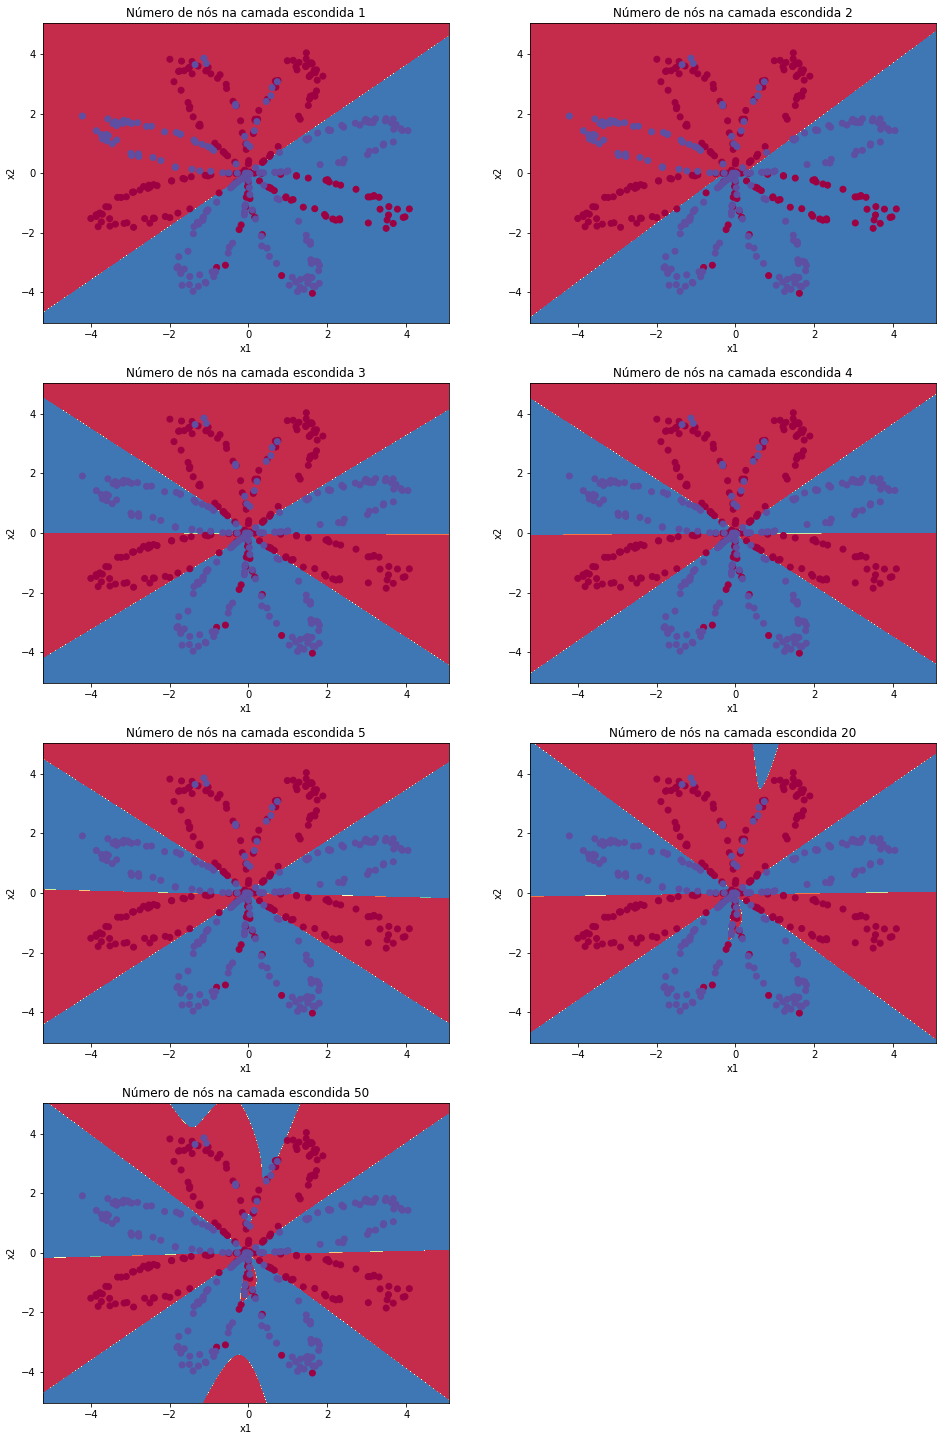

In [26]:
# Isto pode levar uns 2 minutos para ser executado

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Número de nós na camada escondida %d' % n_h)
    parameters = modelo_rn(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: prever(parameters, x.T), X, Y)
    predictions = prever(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Precisão para {} nós escondidos: {} %".format(n_h, accuracy))

**Interpretação**:
- Quanto maior o modelo (com mais nós escondidos) mais fácil é o ajuste no conjunto de treinamento, até que, eventualmente, os modelos maiores se sobreajustam aos dados. 
- O melhor número de nós na camada escondida parece ser algo em torno de n_h = 5. Neste caso, a rede se ajusta aos dados e não apresenta sobreajuste.
- Mais para frente vmos falar sobre regularizacao, que ajuda a utilizar modelos grandes (com n_h = 50) sem que ocorra o sobreajuste.  

**Exercício opcional**:

**Nota**: Lembre-se de salvar a tarefa e criar uma cópia para executar os exercícios opcionais. 

Alguns exercícios opcionais que você pode explorar para entender melhor as redes neurais: 
- O que ocorre se trocamos a função de ativação da tanh para a sigmoid ou a ReLu? 
- Como o modelo se comporta se alteramos a taxa de aprendizado?
- O que ocorre se modificamos o conjunto de dados? (Veja a part 5 abaixo)

<font color='blue'>
**Você Aprendeu:**
- Construir uma rede neural completa com camada escondida.
- Utilizar nós com comportamento não linear.
- Implementar a propagação para frente e para trás e treinar uma rede neural.
- Ver o impacto no modelo ao variar o número de nós na camada escondida, incluindo o sobreajuste.

## 5) Desempenho em outras bases de dados

Se quiser você pode rodar novamente o notebook todo (exceto a parte do conjunto de dados) para cada uma das bases de dados abaixo.

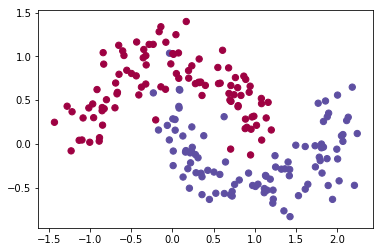

In [27]:
# Bases de dados
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### INICIE O SEU CÓDIGO AQUI ### (escolha a sua base de dados)
dataset = "noisy_moons"
### TÉRMINO DO CÓDIGO ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# fazer blobs binários
if dataset == "blobs":
    Y = Y%2

# Visualizar os dados
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral);

Parabéns, você completou esta tarefa!

Referências:
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/